# <center> NPoS Economics V1 <center>
### <center> Eray Sabancilar, Web3 Foundation, January 20, 2020 <center>

HackMD link to the write up below that is easier to read: https://hackmd.io/CoJKwMDsS8mfzsUQi3Ysyw?view

## Main Asumptions
- A Model with Nominators = Validators. 
- Initial staking bootstrapped from Kusama genesis accounts. 
- No slashing.
- No transaction or commission fees.
- Adjusting stakes once a day.
- Closed system where no external wealth is injected into the system.

## Introduction
In this notebook, we describe a microeconomic model of the NPoS agents (nominators and validators). We design a deterministic dynamic model to simulate NPoS economics and make use of the Kusama genesis balance data to set the initial conditions. The accompanying implemention is given in a jupyter notebook.

We want to answer the following questions with this version of the NPoS economic model:
1. Does the staking rate, $x$, maintain a reasonable value over time, e.g., $x \sim 0.5$?
2. How do inflation, interest rate and staking/liquidity of dots evolve?
3. How does the staking rate and its volatility change over time? 
4. How do validator revenues evolve? Do they ever shrink to zero?
5. How is the wealth distributed over time? Do we observe accumulation of wealth?

### Model Assumptions
1. Basic assumptions:
   - Time is discrete, $t = 0,1,2,...$. 
   - The smallest time scale is an era, which is assumed to be a day long.
   - All nominators are independent. 
2. The nominators are the validators and only back themselves.
3. The half of the balance of the each account at genesis is assumed to be staked initially, i.e., the staking rate, $x(t)$, at the initial state is $x(t=0) \equiv x_0 = 0.5$. The distribution of stakes are bootstrapped from the Kusama account balances at genesis.
4. Payouts go to liquid accounts, whereas the stakes remain in the bonded (chill) account up to a few months.
5. The wealth is assumed to be not compounded since payouts are not automatically staked.
6. The payout to nominator $n$ is given by $P_n(x(t),t) = d_n(t)~r(x(t))$, where $d_n(t)$ is the stake of nominator $n$ and $r(x(t))$ is the daily interest rate.
    - The annual nominal interest rate is: $r^{\rm ann}(x(t)) = I_{NPoS}^{\rm ann}(x(t))/x(t)$
    - The annual inflation rate in terms of the staking rate, $x$, is:
    \begin{align}
    I_{NPoS}^{\rm ann}(x) = \begin{cases}
    I_0 + x\Big(r_{ideal} - I_0/\chi_{ideal}\Big)
    &\text{for } 0<x\leq \chi_{ideal}\\
    I_0 + (r_{ideal}\cdot \chi_{ideal} - I_0)\cdot 2^{(\chi_{ideal}-x)/d}
    &\text{for } \chi_{ideal} < x \leq 1
    \end{cases},
    \end{align}
    where $I_0=0.025$, $\chi_{ideal}=0.5$, $r_{ideal}=0.2$ and $d=0.05$.
    - The daily rates are related to the annual ones via a simple rescaling, $r = r^{\rm ann}/365$, assuming no compounding.
7. Validators are assumed to perform well all the time, i.e., we ignore slashing.
8. The wealth process of a nominator depends on the wealth and the revenue from the previous era only since we assume a closed system with no injection of external funds:
    - $W_n(x(t),t) = W_n(x(t-1),t-1) + d_n(t-1) ~ r(x(t-1))$.
    - The wealth is in nominal terms, i.e., the effect of inflation is not taken into account at this point yet.
    - The nominator nominal return in an era is $R_n(x(t),t) = \frac{W_n(x(t),t)-W_n(x(t-1),t-1)}{W_n(x(t-1),t-1)}$.
    - The nominator real return in an era is $R_n^{\rm real}(x(t),t) = \frac{1+R_n(x(t),t)}{1+I_{NPoS}(x(t-1))} - 1$.
9. A nominator is assumed to make a staking decision every era (day) based on a comparasion of the real return with the opportunity cost of capital.
    - The annual opportunity cost of capital, $R_{\rm opp}^{\rm ann}$, can be calculated, e.g., using a market cap weighted real return of a cryptocurrency portfolio.
10. At the end of every era, nominator $n$ makes a staking decision as follows:
    - If $R_n^{\rm real}(x(t),t) = R_{\rm opp}$, keep stakes the same.
    - If $R_n^{\rm real}(x(t),t) > R_{\rm opp}$, increase stakes.
    - If $R_n^{\rm real}(x(t),t) < R_{\rm opp}$, decrease stakes.
11. A simple staking rate model that captures these properties is: 
$d_n(t) = d_n(t-1) + \alpha W_n(x(t),t)~[R_n^{\rm real}(x(t),t) - R_{\rm opp}]$
where $\alpha>1$ is a parameter, and we impose the following conditions to make sure the staking is bounded within the total wealth of a nominator: 
If $d_n(t) < 0$, $d_n(t) = 0$, and
If $d_n(t) > W_n(x(t),t)$, $d_n(t) =  W_n(x(t),t)$.

### Simulation Specifications for the Nominator Staking & Wealth Processes
1. Set the initial stake distribution of nominators to the half of the genesis account distribution, i.e., assume everybody with an account nominates and stakes half of their initial wealth.
2. At $t=0$, calculate:
    - Initial wealth: $W_n(t=0) = W_n^0$ from the genesis balances.
    - Initial staking: $d_n(t=0) =  0.5 W_n^0$.
    - Initial interest rate: $r(x(t=0)) = r(x_0 = 0.5)$.
    - Set the opportunity cost of capital: $R_{\rm opp} = 0.05/365$.
3. At any time $t$:
    - Calculate wealth: $W_n(x(t),t)$.
    - Calculate return: $R_n(x(t),t)$. 
    - Check the staking condition and execute the decision.
    - Calculate staking rate: $d_n(t)$.
    - Calculate staking rate: $x(t)$.
    - Calculate inflation rate: $I_{NPoS}(x(t))$.
    - Calculate nominal interest rate: $r(x(t))$.
    - Calculate real interest rate: $r_{\rm real}(x(t))$.
    - Store nominator related variables in a matrix of size $(t+1) \times 3N$: 
        $M_n \equiv [W_n(x(t),t), R_n(x(t),t), d_n(t)]$.
    - Store global variables in a matrix of size $(t+1) \times 4$ 
$G_n \equiv [x(t), I_{NPoS}(x(t)), r(x(t)), r_{\rm real}(x(t))]$.
4. Run the model upto $t = T = 365$.
5. Report the time series of $x(t), I_{NPoS}^{\rm ann}(x(t)), r^{\rm ann}(x(t)), r_{\rm real}^{\rm ann}(x(t))$.

## 1. Kusama Genesis Balances

### 1.1. Importing Kusama Genesis Address & Balance Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import scipy as sp 
#import scipy.stats as sps 
#from statsmodels.distributions.empirical_distribution import ECDF

# Import data
data = pd.read_csv("kusamaGenesisBalances.csv")

# Convert balances into units of Kusamas
data['Balance'] = data['Balance']*(10**(-12))

# Reorder data by balance amounts
data = data.sort_values(by='Balance', ascending=False)
nAccounts = data.values.size/2
print("The number of all accounts at genesis is {}.".format(nAccounts))

# Total and median amounts in the balances
sumKSM = data["Balance"].sum()
print("The total amount in the balances is {} million Kusamas.".format(round(sumKSM/10**6,3)))
medianKSM = round(data["Balance"].median(),3)
print("The median account balance is {} Kusamas.".format(medianKSM))

The number of all accounts at genesis is 381.0.
The total amount in the balances is 3.433 million Kusamas.
The median account balance is 211.051 Kusamas.


### 1.2. Exploratory Data Analysis

In [2]:
# The first few rows of the sorted dataset
data.head(4)

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


In [3]:
# The last few rows of the sorted dataset
data.tail(4)

,Address,Balance
269,5HjgWVF8CuP3xMsBmg4SKfK8Wvbhi6xoREs63YKfwZMAqy2r,0.01
311,5HNNjonNAftjHTToLpf5iyYeir2NDYnBdcRiwyJkP4Ra76QW,0.01
310,5CAWmjDvXUxrwThznrsMy5WwpH714NwJcMirqXQifLXQw4Li,0.01
298,5G6GU1xmqxmLmPQ2L9pXtqNiRdcGG31cbq63mf3TU7Z4BPDU,0.01


Since 0.01 Kusama is not enough to do anything practical other than keeping a Kusama account, we drop those balances from the dataset.

In [4]:
# Indicies of balances without 0.01 Kusama
idx = data["Balance"].loc[data["Balance"] != 0.01].index 

# Data without 0.01 Kusama accounts
dataClean = data.loc[idx]

# Check the first and the last few rows of ordered balances
display(dataClean.head(4))
display(dataClean.tail(4))

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


,Address,Balance
193,5H1DvSQVg8wGHiiP2ugdHQQUU7TUNAcL7cg6XYsnAFCDz63f,5.276
232,5DLB96CJ62oWhfUiLNN36tM9KmpU789dW5qRzCB3PTg2VBYD,4.588
19,5EyErcfEJTjKJjE4tDiPZNyAhCAqpckkNPo9Ncjod8yhZr7Z,2.661
258,5C5CHDNR2mgsy48eopGp1BcZ29EYM5dxMBNEAe5VpX4cPjKY,0.825


In [5]:
# Number of accounts in the clean dataset
nAccountsClean = dataClean.values.size/2
print("The number of accounts at genesis with more than 0.01 KSM is {}.".format(nAccountsClean))
print("Thus, there are {} accounts with 0.01 KSM that we drop in what follows.".format(nAccounts - nAccountsClean))

The number of accounts at genesis with more than 0.01 KSM is 339.0.
Thus, there are 42.0 accounts with 0.01 KSM that we drop in what follows.


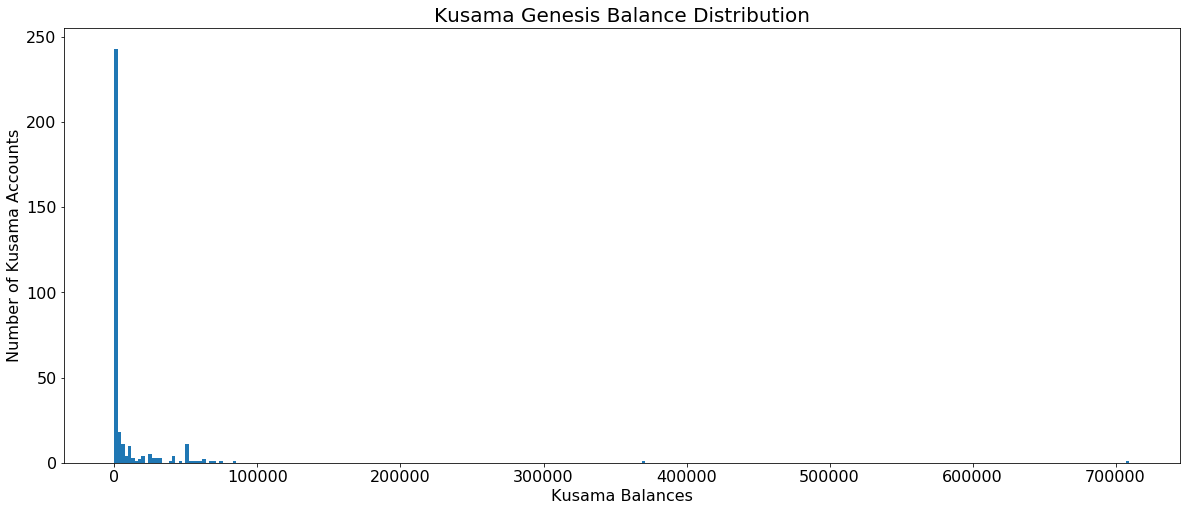

In [6]:
# Histogram of Kusama balances ignoring accounts with <= 0.01 KSM
plt.figure(figsize=(20,8))
plt.hist(dataClean["Balance"],300)
plt.xlabel('Kusama Balances',fontsize = 16)
plt.ylabel('Number of Kusama Accounts',fontsize = 16)
plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('KusamaGenesisBalances.pdf')

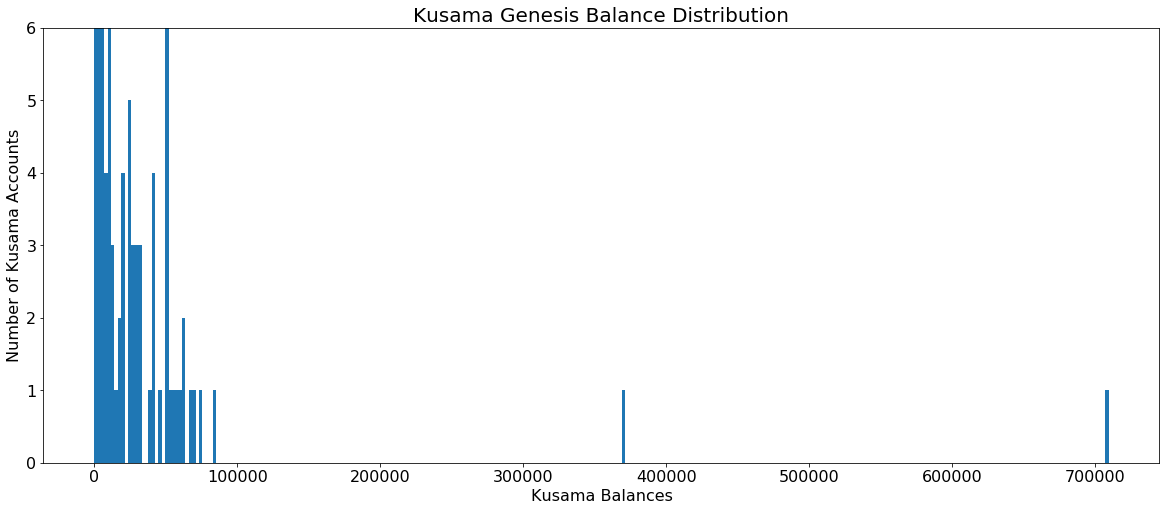

In [7]:
# Zooming into the figure
plt.figure(figsize=(20,8))
plt.hist(dataClean["Balance"],300)
plt.xlabel('Kusama Balances',fontsize = 16)
plt.ylabel('Number of Kusama Accounts',fontsize = 16)
plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,6])
plt.show()

In [8]:
#outlierShare
round((dataClean["Balance"][1]+dataClean["Balance"][2])*100/sumKSM,2)

12.22

We observe two outlier account balances with 709,346.898 & 369,340.969 KSM, whereas the lowest balance has 0.825 KSM. The largest two balances hold 12.22 % share of the whole Kusamas at genesis.

# 2. Initial Conditions

In [9]:
# Initial nominator wealth
w_0 = dataClean['Balance'].values
# Fraction of stakes from the Kusama genesis balances
f_0 = 0.5
# Initial staking
d_0 = f_0*w_0
# Inflation parameters
I_0 = 0.025 
chi_ideal = 0.5
r_ideal = 0.2
d_shift = 0.05
# Total time length
year = 5
T = 366*year
# Annual opportunity cost of capital
R_opp = 0.05
# Staking decision parameter
alpha = 20

# 3. Function Definitions

## 3.1. Inflation and Interest Rates 

In [10]:
# Annual inflation rate as a function of the staking rate x
# ->Input parameters:
# I_0: inflation 
# chi_ideal: ideal staking rate
# r_ideal: ideal interest rate
# d_shift: shift parameter
# Input variable:
# x: staking rate as a number
# Output->:
# annualInflation: annual inflation rate
def annualInflation(I_0, chi_ideal, r_ideal, d_shift, x):
    if 0 <= x <= chi_ideal:
        I = I_0 + (r_ideal - I_0/chi_ideal)*x
    if chi_ideal < x <= 1:
        I = I_0 + (r_ideal*chi_ideal - I_0)*2**((chi_ideal - x)/d_shift)
    return I

# Annual interest rate
# ->Input parameters: I_0, chi_ideal, r_ideal, dinf
# Input variable:
# x: staking rate as a number
# Output->:
# annualInterest: annual inflation rate
def annualInterest(I_0, chi_ideal, r_ideal, d_shift, x):
    if 0<= x < 0.00001:
        r = 2.62
    else:
        r = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x)/x
    return r

## 3.2. Plot of Inflation and Interest Rates

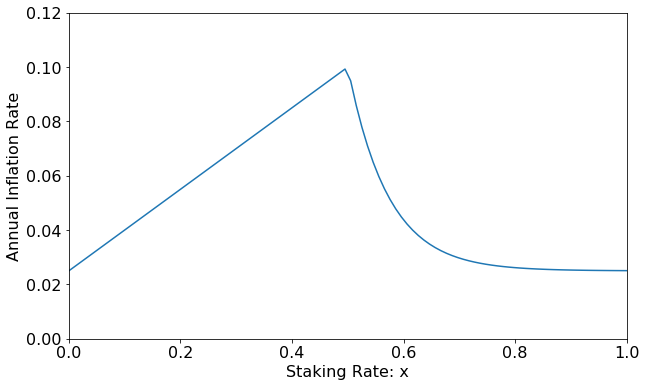

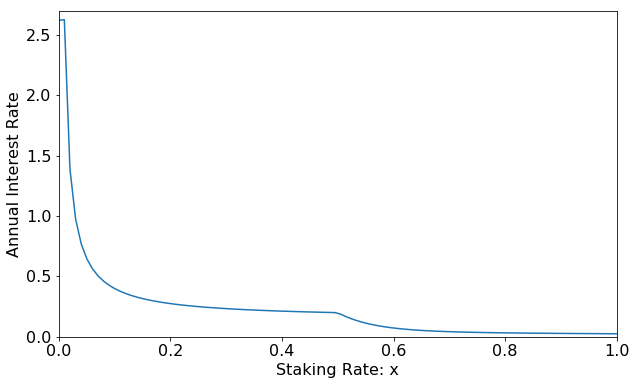

In [11]:
# Plot the annual NPoS inflation and interest rate curves
xlin = np.linspace(0, 1, 100, endpoint=True)
Ilin = np.zeros(len(xlin))
rlin = np.zeros(len(xlin))
for i in range(0,len(xlin)):
    Ilin[i] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, xlin[i])
    rlin[i] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, xlin[i])

plt.figure(figsize=(10,6))
plt.plot(xlin, Ilin)
plt.xlabel('Staking Rate: x',fontsize=16)
plt.ylabel('Annual Inflation Rate',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
axes.set_ylim([0,0.12])
axes.set_xlim([0,1])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(xlin, rlin)
plt.xlabel('Staking Rate: x',fontsize=16)
plt.ylabel('Annual Interest Rate',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
axes.set_ylim([0,2.7])
axes.set_xlim([0,1])
plt.show()

## 3.2. NPoS Economic Model

In [12]:
# NPoSEcononomics function calculates nominal wealth, return, staking process of a nominator 
# as well as the staking, inflation and interest rates in each era t
def NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift, w_0, d_0, T, R_opp, alpha): 
    
    # Pre-allocate w, d, R, I, r, x matrices
    # Nominal wealth of a nominator
    w = np.zeros((T+1,w_0.size))
    # Nominator stake
    d = np.zeros((T+1,d_0.size))
    # Nominal retun on stake
    R = np.zeros((T+1,d_0.size))
    # Real return on stake
    R_real = np.zeros((T+1,d_0.size))
    # Inflation rate
    I = np.zeros((T+1,1))
    # Interest rate
    r = np.zeros((T+1,1))
    # Staking rate
    x = np.zeros((T+1,1))
    # Unit vector of size equal to the number of nominators
    idN = np.ones((1,w_0.size))
    # Vector of zeros of size equal to the number of nominators
    zeroN = np.zeros((1,w_0.size,))
                  
    # Set initial values
    w[0,:] = w_0
    d[0,:] = d_0
    x[0] = sum(d_0)/sum(w_0)
    I[0] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x[0])
    r[0] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, x[0])
    
    # Update values of these matrices in time
    t = 1
    while t <= T:
        # Calculate the wealth at time t, note the conversion from annual to daily interest rate
        w[t,:] = w[t-1,:] + d[t-1,:]*(r[t-1]/365)
        # Calculate the nominal daily return at time t from staking at time t-1
        R[t,:] = np.true_divide(w[t,:] - w[t-1,:],w[t-1,:])
        # Calculate the real daily return
        R_real[t,:] =  ((idN + R[t,:])/(1 + I[t-1]/365)) - idN
        # Update the stake based on the comparison of the real return with the opportunity cost of capital
        d[t,:] = d[t-1,:] + alpha*np.multiply(w[t,:],(R[t,:] - (R_opp/365)*idN))
        #d[t,:] = d[t-1,:] + alpha*np.multiply(w[t,:],(R_real[t,:] - (R_opp/365)*idN))
        # Boundary conditions for d_t
        for i in range(0,w_0.size):
            if np.sign(d[t,i]) == -1:
                d[t,i] = 0
            if np.sign(d[t,i] - w[t,i]) == 1:
                d[t,i] = w[t,i]
        # Calculate the staking rate
        x[t] = sum(d[t,:])/sum(w[t,:])
        # Calculate the inflation rate
        I[t] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x[t])
        r[t] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, x[t])
        # Switch to the next time step
        t = t + 1
    return w, R, R_real, d, x, I, r

In [13]:
# Run the NPoSEconomics function 
M = NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift, w_0, d_0, T, R_opp, alpha)
# Save the output
w = M[0]
R = M[1]
R_real = M[2]
d = M[3]
x = M[4]
I = M[5]
r = M[6]
t = np.linspace(0, T, T+1)

## 3.3. Summary Plots

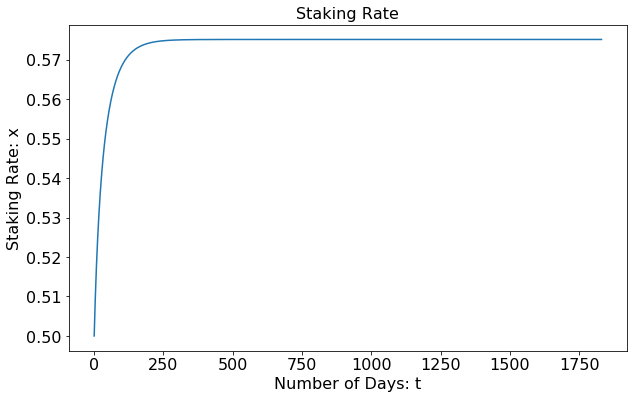

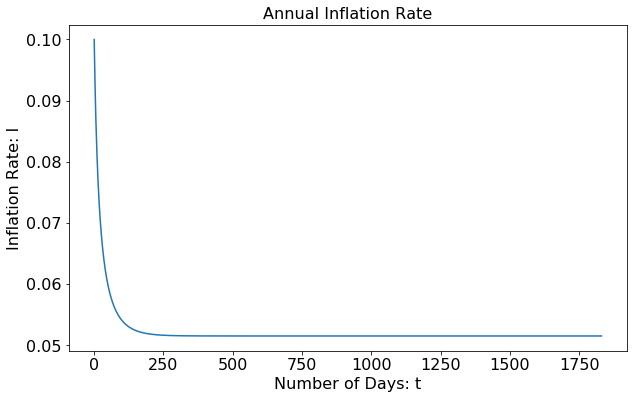

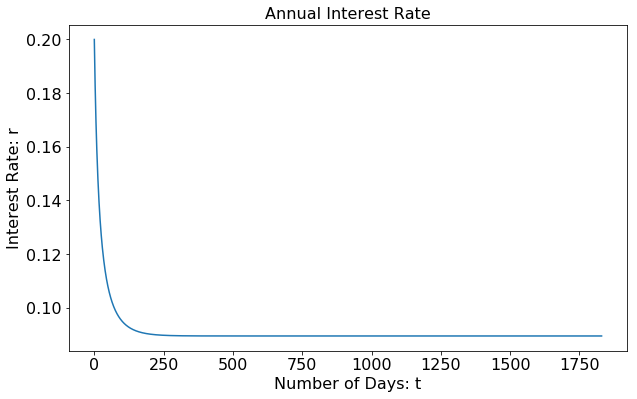

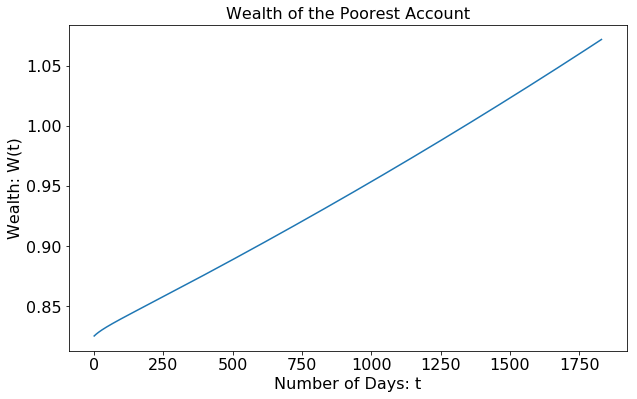

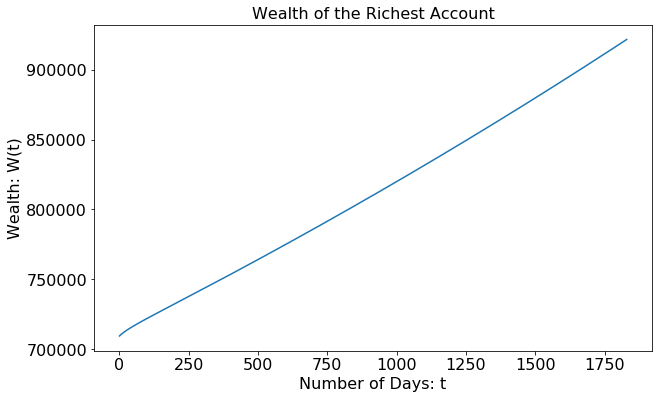

In [14]:
plt.figure(figsize=(10,6))
plt.plot(t, x)
plt.title('Staking Rate',fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Staking Rate: x',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t, I)
plt.title('Annual Inflation Rate',fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Inflation Rate: I',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t, r)
plt.title('Annual Interest Rate',fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Interest Rate: r',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t, w[:,-1])
plt.title('Wealth of the Poorest Account',fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Wealth: W(t)',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t, w[:,0])
plt.title('Wealth of the Richest Account',fontsize=16)
plt.xlabel('Number of Days: t',fontsize=16)
plt.ylabel('Wealth: W(t)',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
plt.show()